<style>
    .logo {
        position: relative;
        float: left;
        margin-right: 15px;
    }
</style>

<div style="display: flex; align-items: center;">
    <img src="img/TelecomParis.png" width="80" height="80" class="logo">
</div>
<center>
    <h3>IMA201</h3><br></br>
    <h2>Compte rendu du TP 1</h2>
    <h3>Réalisé par : BOUZID Atef</h3>
    <h4>2024-2025</h4>
</center>


# 1. Préliminaires 
## Inclusion de packages externes 

In [1]:
import numpy as np
import platform
import tempfile
import os
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
# necessite scikit-image 
from skimage import io as skio

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

## Fonctions utiles

In [3]:
def viewimage(im,normalise=True,MINI=0.0, MAXI=255.0):
    """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS 
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee 
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI et MAXI seront mis a 0 et 255 dans l'image resultat
        
    """
    imt=np.float32(im.copy())
    if platform.system()=='Darwin': #on est sous mac
        prephrase='open -a GIMP '
        endphrase=' ' 
    elif platform.system()=='Windows': 
        #ou windows ; probleme : il faut fermer gimp pour reprendre la main; 
        #si vous savez comment faire (commande start ?) je suis preneur 
        prephrase='"C:/Program Files/GIMP 2/bin/gimp-2.10.exe" '
        endphrase=' '
    else: #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais pas comment faire. Si vous savez dites-moi.)
        prephrase='gimp '
        endphrase= ' &'
    
    if normalise:
        m=im.min()
        imt=imt-m
        M=imt.max()
        if M>0:
            imt=255*imt/M

    else:
        imt=(imt-MINI)/(MAXI-MINI)
        imt[imt<0]=0
        imt[imt>1]=1
        imt *= 255
    
    nomfichier=tempfile.mktemp('TPIMA.png')
    commande=prephrase +nomfichier+endphrase
    imt = imt.astype(np.uint8)
    skio.imsave(nomfichier,imt)
    os.system(commande)

def viewimage_color(im,normalise=True,MINI=0.0, MAXI=255.0):
    """ Cette fonction fait afficher l'image EN COULEURS
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee 
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI(defaut 0) et MAXI (defaut 255) seront mis a 0 et 255 dans l'image resultat
        
    """
    imt=np.float32(im.copy())
    if platform.system()=='Darwin': #on est sous mac
        prephrase='open -a GIMP '
        endphrase= ' '
    elif platform.system()=='Windows': 
        #ou windows ; probleme : il faut fermer gimp pour reprendre la main; 
        #si vous savez comment faire (commande start ?) je suis preneur 
        prephrase='"C:/Program Files/GIMP 2/bin/gimp-2.10.exe" '
        endphrase=' '
    else: #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais comment faire. Si vous savez dites-moi.)
        prephrase='gimp '
        endphrase=' &'
    
    if normalise:
        m=imt.min()
        imt=imt-m
        M=imt.max()
        if M>0:
            imt=255*imt/M
    else:
        imt=(imt-MINI)/(MAXI-MINI)
        imt[imt<0]=0
        imt[imt>1]=1
        imt *= 255
    
    nomfichier=tempfile.mktemp('TPIMA.pgm')
    commande=prephrase +nomfichier+endphrase
    imt = imt.astype(np.uint8)
    skio.imsave(nomfichier,imt)
    os.system(commande)

def noise(im,br):
    """ Cette fonction ajoute un bruit blanc gaussier d'ecart type br
       a l'image im et renvoie le resultat"""
    imt=np.float32(im.copy())
    sh=imt.shape
    bruit=br*np.random.randn(*sh)
    imt=imt+bruit
    return imt

def quantize(im,n=2):
    """
    Renvoie une version quantifiee de l'image sur n (=2 par defaut) niveaux  
    """
    imt=np.float32(im.copy())
    if np.floor(n)!= n or n<2:
        raise Exception("La valeur de n n'est pas bonne dans quantize")
    else:
        m=imt.min()
        M=imt.max()
        imt=np.floor(n*((imt-m)/(M-m)))*(M-m)/n+m
        imt[imt==M]=M-(M-m)/n #cas des valeurs maximales
        return imt
    

def seuil(im,s):
    """ renvoie une image blanche(255) la ou im>=s et noire (0) ailleurs.
    """
    imt=np.float32(im.copy())
    mask=imt<s
    imt[mask]=0
    imt[~mask]=255
    return imt

def gradx(im):
    "renvoie le gradient dans la direction x"
    imt=np.float32(im)
    gx=0*imt
    gx[:,:-1]=imt[:,1:]-imt[:,:-1]
    return gx

def grady(im):
    "renvoie le gradient dans la direction y"
    imt=np.float32(im)
    gy=0*imt
    gy[:-1,:]=imt[1:,:]-imt[:-1,:]
    return gy

def view_spectre(im,option=1,hamming=False):
    """ affiche le spectre d'une image
     si option =1 on affiche l'intensite de maniere lineaire
     si option =2 on affiche le log
     si hamming=True (defaut False) alors une fenetre de hamming est appliquee avant de prendre la transformee de Fourier
     """
    imt=np.float32(im.copy())
    (ty,tx)=im.shape
    pi=np.pi
    if hamming:
        XX=np.ones((ty,1))@(np.arange(0,tx).reshape((1,tx)))
        YY=(np.arange(0,ty).reshape((ty,1)))@np.ones((1,tx))
        imt=(1-np.cos(2*pi*XX/(tx-1)))*(1-np.cos(2*pi*YY/(ty-1)))*imt
    aft=np.fft.fftshift(abs(np.fft.fft2(imt)))
    
    if option==1:
        plt.imshow(aft,cmap='gray')
    else:
        plt.imshow(np.log(0.1+aft),cmap='gray')


def filterlow(im): 
    """applique un filtre passe-bas parfait a une image (taille paire)"""
    (ty,tx)=im.shape
    imt=np.float32(im.copy())
    pi=np.pi
    XX=np.concatenate((np.arange(0,tx/2+1),np.arange(-tx/2+1,0)))
    XX=np.ones((ty,1))@(XX.reshape((1,tx)))
    
    YY=np.concatenate((np.arange(0,ty/2+1),np.arange(-ty/2+1,0)))
    YY=(YY.reshape((ty,1)))@np.ones((1,tx))
    mask=(abs(XX)<tx/4) & (abs(YY)<ty/4)
    imtf=np.fft.fft2(imt)
    imtf[~mask]=0
    return np.real(np.fft.ifft2(imtf))

def filtergauss(im):
    """applique un filtre passe-bas gaussien. coupe approximativement a f0/4"""
    (ty,tx)=im.shape
    imt=np.float32(im.copy())
    pi=np.pi
    XX=np.concatenate((np.arange(0,tx/2+1),np.arange(-tx/2+1,0)))
    XX=np.ones((ty,1))@(XX.reshape((1,tx)))
    
    YY=np.concatenate((np.arange(0,ty/2+1),np.arange(-ty/2+1,0)))
    YY=(YY.reshape((ty,1)))@np.ones((1,tx))
    # C'est une gaussienne, dont la moyenne est choisie de sorte que
    # l'integrale soit la meme que celle du filtre passe bas
    # (2*pi*sig^2=1/4*x*y (on a suppose que tx=ty))
    sig=(tx*ty)**0.5/2/(pi**0.5)
    mask=np.exp(-(XX**2+YY**2)/2/sig**2)
    imtf=np.fft.fft2(imt)*mask
    return np.real(np.fft.ifft2(imtf))

# 2. Visualisation et utilisation de GIMP

<img src='report/1.png' style="width:500px; align:'center'" >

## 2.1 Zoom:

En fait, Zoomer sur une image ne crée pas plus de détails supplémentaires, mais agrandit simplement les pixels existants.
<table><tr>
<td> <img src="report/2-petit.png" style="width: 400px;"/> </td>
<td> <img src="report/2-petit zoomed.png" style="width: 400px;"/>  </td> 
   
</tr></table>


Lorsque on compare les images "maison_petit.tif" ,echelle 100%, (à gauche) ,  et la redimensionnée echelle 200%, (à droite), on remarque une différence de qualité. Cela est dû à la perte d'informations lors du redimensionnement d'une image.

> **La réduction d'echelle d'une image, entraine une perte d'information, ce qui explique la différence de qualité lorsque on zoom sur l'image réduite par rappot à l'image originale. Cette perte d'information est due au processus de rééchantillonnage, ou des pixels sont supprimés ou interpolés**

## 2.2 Espace couleurs

<center> <img src="report/fleur.png"= style="width: 400px;"/><p>Originale</p>  </center>
<table><tr>
    <td> <img src="report/3.png"= style="width: 400px;"/> <p>Hue : 180°</p>  </td> 
   
<td> <img src="report/3.png" style="width: 400px;"/> <p>Hue : -180°</p></td>
    
</tr></table>

<table><tr>
    <td> <img src="report/3 sat 100.png"= style="width: 400px;"/> <p>image pour stauration 100%</p>  </td> 
   
<td> <img src="report/3 sat -100.png" style="width: 400px;"/> <p> image pour saturation -100%</p></td>
    
</tr></table>

Le faite que les positions extrêmes du bouton 'Teinte' prouduisent le même résultat s'explique par le caractère circulaire de l'espace des teintes --> **Une rotation de 360° ramène à la couleur d'origine.**
> La saturation contrôle l'intensité de la couleur -> Une saturation à 100% donne des couleurs vives et intenses, tandis qu'une saturation à -100% produit une image en niveaux de gris. 

# 3. Niveaux de grix, histogrammes et statistiques

## 3.1 Histogramme

L'histogramme est un outil fondamental en traitement d'image. Il permet de visualiser la distribution des niveaux de gris (ou des couleurs) dans une image.

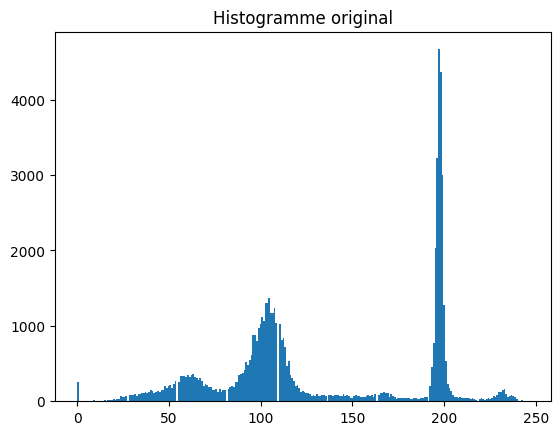

In [4]:
im=skio.imread('images/maison.tif')

plt.hist(im.reshape((-1,)),bins=255) #le reshape transforme en tableau 1D
plt.title('Histogramme original')
plt.show()

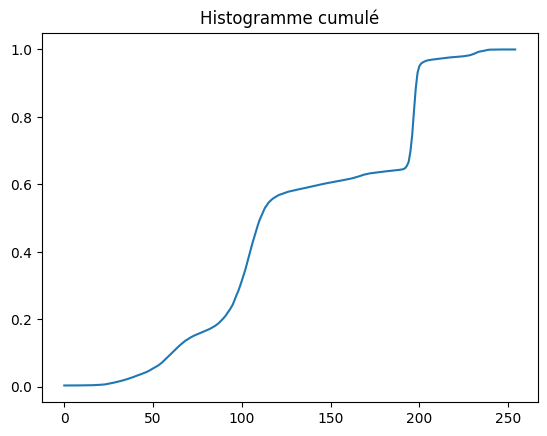

In [5]:
(histo,bins)=np.histogram(im.reshape((-1,)),np.arange(0,256)) #le reshape est inutile pour np.histogram, mais on le laisse pour la compatibilite avec plt.hist
histo=histo/histo.sum()
histocum=histo.cumsum()
plt.title('Histogramme cumulé')
plt.plot(histocum)
plt.show()

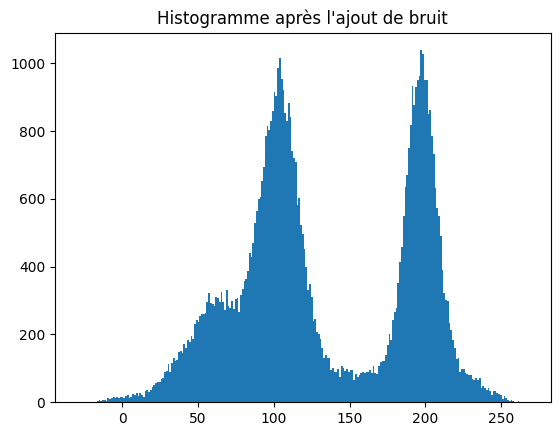

In [6]:
plt.title("Histogramme après l'ajout de bruit")
imbr=noise(im,10)
plt.hist(imbr.reshape((-1,)),255)
plt.show()

<div><h4>L'image après l'ajout du bruit</h4><img src="report/4 noise add.png"= style="width: 400px;"/> </div>

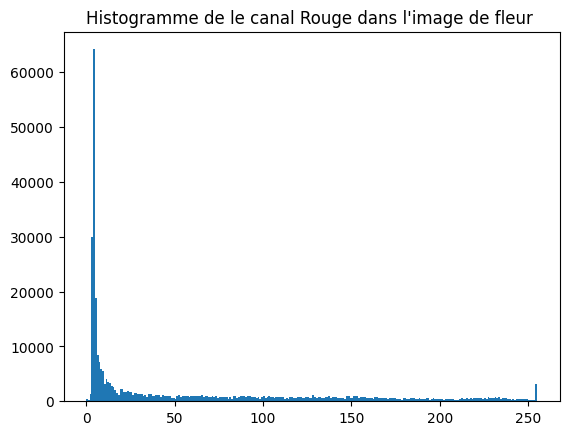

In [7]:
imcol = skio.imread('images/fleur.tif')
rouge =imcol[:,:,0]
im = imcol.mean(axis=2) 
plt.title('Histogramme de le canal Rouge dans l\'image de fleur ')
plt.hist(rouge.reshape((-1,)),bins=255)
plt.show()

Le bruit blanc gaussien ajouté à l'image a pour effet d'élargir la distribution des niveaux de gris.
Cela se traduit par un histogramme plus étalé, avec une augmentation de la variance.
Les pics de l'histogramme original sont adoucis et les valeurs de gris deviennent plus dispersées.
En d'autres termes, le bruit introduit des variations aléatoires qui augmentent la diversité des niveaux de gris, rendant l'image plus granuleuse et moins uniforme.

> **L'ajout de bruit gaussien à une image élargit son histogramme.**

## 3.2 Changement de contraste

<table><tr>
<td> <img src="report/5 croissante.png"= style="width: 400px;"/> <p>Fonction croissante</p>  </td> 
<td> <img src="report/5 decroissante.png"= style="width: 400px;"/> <p>Fonction décroissante</p>  </td> 
</table>


- L'application de fonctions croissantes, comme une courbe en S, augmente généralement le contraste de l'image. Cela se produit parce que les niveaux de gris sont étirés, ce qui rend les zones claires plus claires et les zones sombres plus sombres. En conséquence, les détails de l'image deviennent plus prononcés et l'image apparaît plus nette.

- Lorsque on applique une transformation non-croissante, comme une courbe en forme de U inversé, le contraste de l'image peut être réduit ou certaines parties de l'image peuvent être inversées. Cela signifie que les niveaux de gris peuvent être compressés, ce qui rend les zones claires et sombres plus similaires. En conséquence, l'image peut apparaître plus plate et moins détaillée.

- Ajout d'une constante (luminosité) : L'ajout d'une constante déplace tous les niveaux de gris de manière uniforme. Cela signifie que l'image entière devient plus claire ou plus sombre, selon la valeur de la constante ajoutée. Par exemple, ajouter une constante positive éclaircit l'image, tandis qu'ajouter une constante négative l'assombrit.

- Multiplication par une constante après centrage (contraste) : La multiplication par une constante après centrage augmente ou diminue le contraste de l'image. Cela se fait en centrant les niveaux de gris autour d'une valeur centrale (par exemple, 128) et en les étirant ou en les compressant. Une constante supérieure à 1 augmente le contraste en étirant les niveaux de gris, tandis qu'une constante inférieure à 1 diminue le contraste en les compressant.

> **La modification du contraste vise à améliorer la différence entre les zones claires et sombres d'une image**
> 
> **Fonction Croissante -> augmente le contraste -> image plus nette**
> 
> **Fonction décroissante -> reduire le contraste et inverser certaines parties de l'image, -> image moins detaillée**

## 3.3 Egalisation d'histogramme

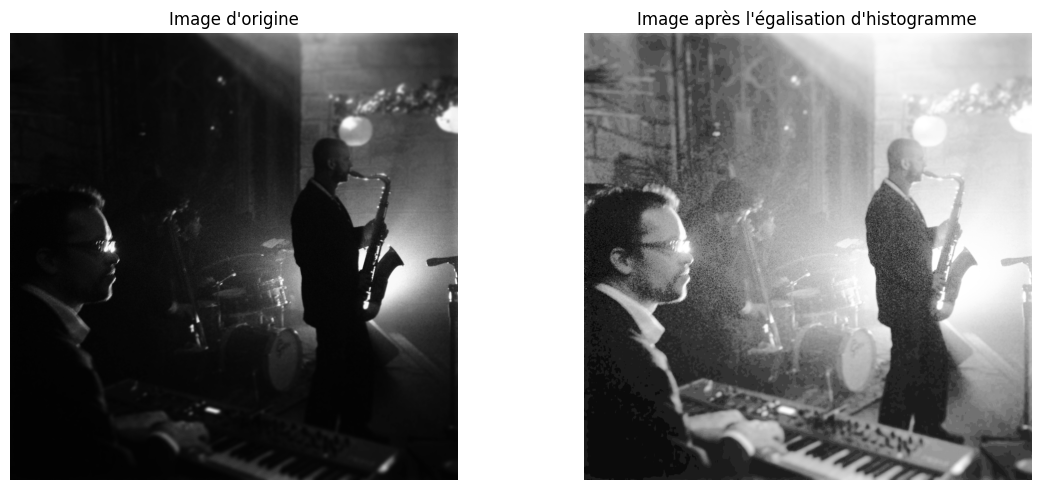

In [8]:
# Lire l'image
im = skio.imread('images/sombre.jpg')
im=im.mean(axis=2)
(histo,bins)=np.histogram(im.reshape((-1,)),np.arange(0,256)) #le reshape en inutile pour np.histogram, mais on le laisse pour la compatibilite avec plt.hist
histo=histo/histo.sum()
histocum=histo.cumsum()
imequal=histocum[np.uint8(im)]*255

# Créer un subplot pour afficher les images
plt.figure(figsize=(12,5))

# Afficher l'image d'origine
plt.subplot(1, 2, 1)
plt.imshow(im,cmap="gray")
plt.title('Image d\'origine')  
plt.axis('off')

# Afficher l'image en niveaux de gris
plt.subplot(1, 2, 2)
plt.imshow(imequal, cmap='gray') 
plt.title('Image après l\'égalisation d\'histogramme') 
plt.axis('off') 

# Afficher le subplot
plt.tight_layout()
plt.show()

In [9]:
(histo2,bins1)=np.histogram(imequal.reshape((-1,)),np.arange(0,256))
histo2=histo2/histo2.sum()
histocum2=histo2.cumsum()

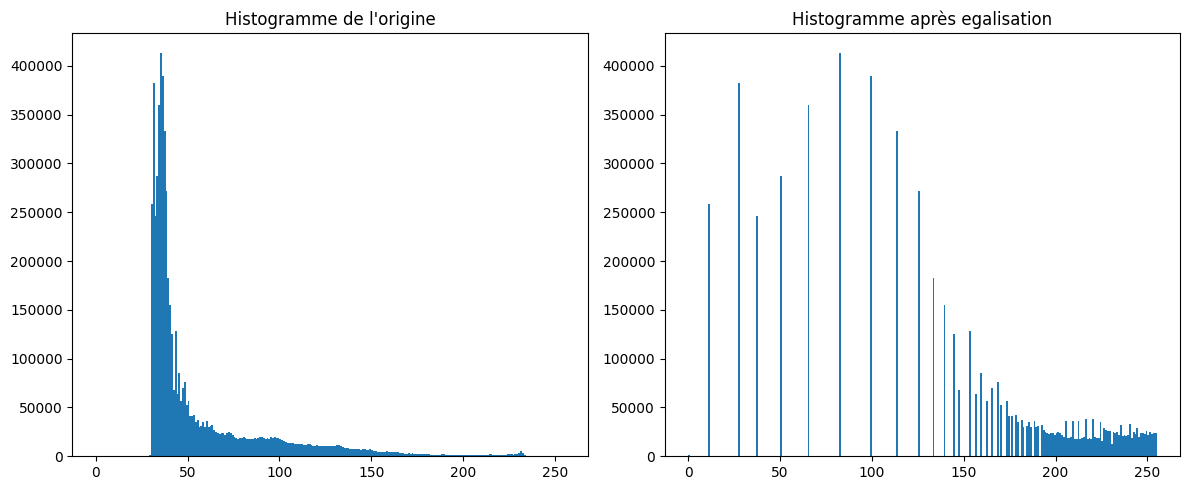

In [10]:
plt.figure(figsize=(12,5))


plt.subplot(1, 2, 1)
plt.hist(im.reshape((-1,)),np.arange(0,256))
plt.title('Histogramme de l\'origine') 


plt.subplot(1, 2, 2)
plt.hist(imequal.reshape((-1,)),np.arange(0,256))
plt.title('Histogramme après egalisation')  

plt.tight_layout()
plt.show()

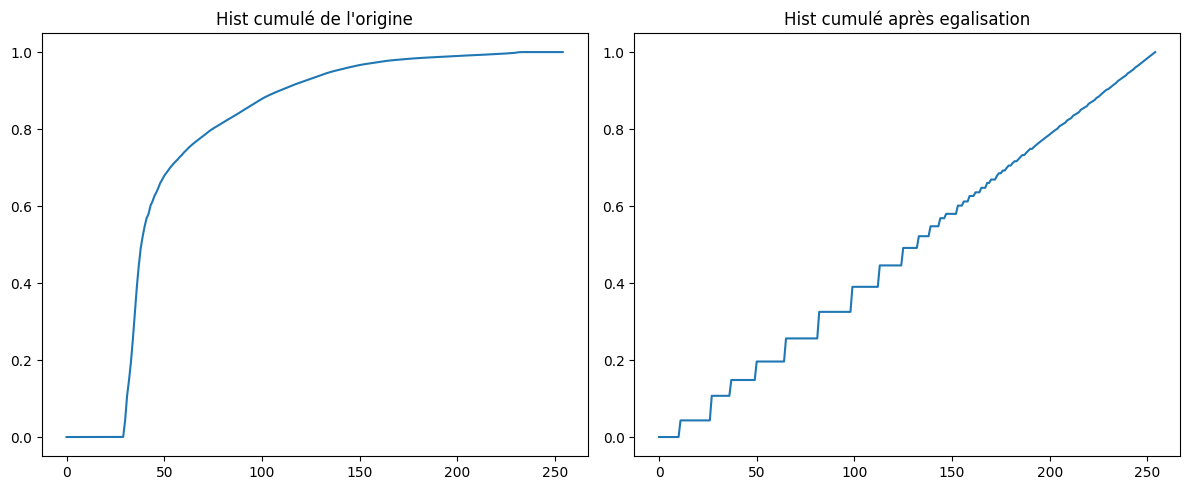

In [11]:
plt.figure(figsize=(12,5))


plt.subplot(1, 2, 1)
plt.plot(histocum)
plt.title('Hist cumulé de l\'origine') 


plt.subplot(1, 2, 2)
plt.plot(histocum2)
plt.title('Hist cumulé après egalisation')  

plt.tight_layout()
plt.show()

### Observations :
 1. Sur imequal :
    - L'image imequal résultante aura un contraste amélioré par rapport à l'image originale im.
    - Les détails dans les zones sombres et claires seront plus visibles.
    - L'image semblera plus équilibrée en termes de luminosité, avec une distribution plus uniforme des niveaux de gris.

 2. Sur l'histogramme de imequal :
    - L'histogramme de imequal sera plus uniforme que celui de l'image originale.
    - Les niveaux de gris seront répartis de manière plus égale sur toute la plage de valeurs possibles (0 à 255).
    - Les pics présents dans l'histogramme original seront atténués, et les creux seront remplis, résultant en une distribution plus plate.

 3. Sur l'histogramme cumulé de imequal :
    - L'histogramme cumulé de imequal sera une ligne droite ascendante, indiquant une distribution uniforme des niveaux de gris.
    - Cela montre que chaque niveau de gris a une probabilité égale d'occurrence, ce qui est l'objectif de l'égalisation d'histogramme.

## 3.4 Prescription d'histogramme

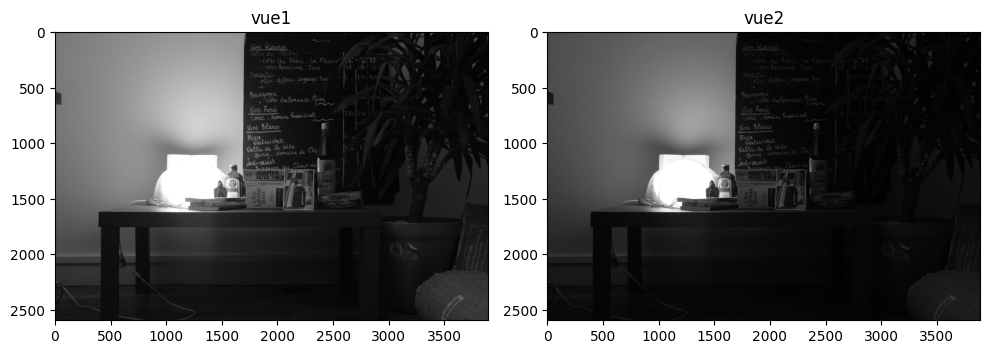

In [12]:
plt.figure(figsize=(10,5))
u=skio.imread('images/vue1.tif')
v=skio.imread('images/vue2.tif')
plt.subplot(1,2,1)
plt.imshow(u,cmap='gray')
plt.title('vue1')

plt.subplot(1,2,2)
plt.imshow(v,cmap='gray')
plt.title('vue2')


plt.tight_layout()
plt.show()

In [13]:
if u.shape==v.shape: 
    print("Ces deux images ont mêmes dimensions")

Ces deux images ont mêmes dimensions


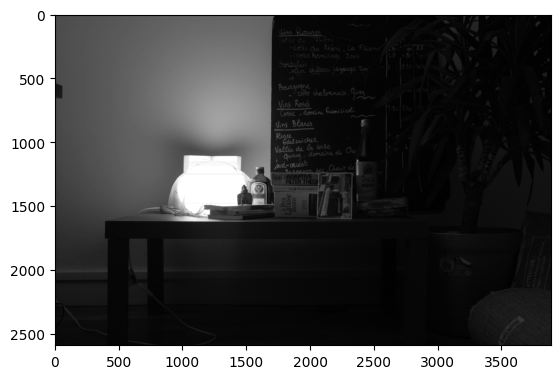

In [14]:
ushape=u.shape
uligne=u.reshape((-1,)) #transforme en ligne
vligne=v.reshape((-1,))
ind=np.argsort(uligne)
unew=np.zeros(uligne.shape,uligne.dtype)
unew[ind]=np.sort(vligne)
# on remet a la bonne taille
unew=unew.reshape(ushape)

plt.imshow(unew,cmap='gray')
plt.show()

> **On a utilisé la prescription d'histogramme pour donner à 'vue1.tif' l'histogramme de 'vue2.tif'. Cette technique est particulièrement utile pour comparer des images prises dans des conditions d'éclairage différentes.**

> **Il est vrai qu'appliquer l’histogramme d’une image à une autre image via la prescription d'histogramme aura comme résultat que les deux images auront le même histogramme. Cependant, cela ne signifie pas que les deux images seront identiques visuellement, ni que leur différence sera une image noire.**

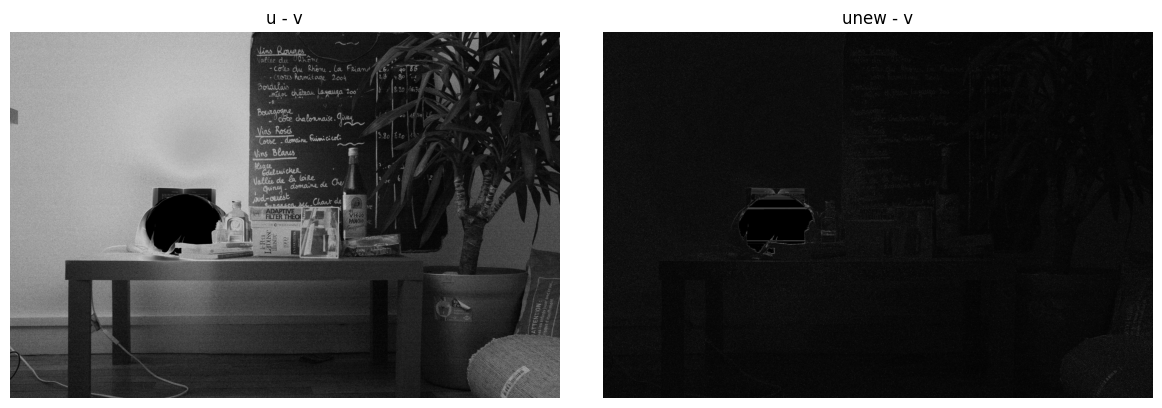

In [15]:
subplot_params = [
        {'position': (0, 0), 'size': (1, 1)},
        {'position': (0, 1), 'size': (1, 1)}
    ]

fig_size= (12,8)

fig = plt.figure(figsize=fig_size)

# subplot: u - v
ax1 = plt.subplot2grid((2, 2), 
                       subplot_params[0]['position'], 
                       colspan=subplot_params[0]['size'][0], 
                       rowspan=subplot_params[0]['size'][1])
im1 = ax1.imshow(abs(np.float32(u) - np.float32(v)), cmap='gray')
ax1.set_title('u - v')
ax1.axis('off')

# subplot: unew - v
ax2 = plt.subplot2grid((2, 2), 
                       subplot_params[1]['position'], 
                       colspan=subplot_params[1]['size'][0], 
                       rowspan=subplot_params[1]['size'][1])
im2 = ax2.imshow(abs(np.float32(unew) - np.float32(v)), cmap='gray')
ax2.set_title('unew - v')
ax2.axis('off')

plt.tight_layout()
plt.show()

Le moyen le plus simple d'obtenir le même resultat est de connaitre le temps d'exposition de chacun image et faire tout simplement la multiplication par le rapport de temps d'exposition.

Pour égaliser l'histogramme d'une maniere plus simple on peut le donner l'histogramme d'une image ayant un histogramme constant donc on genere un ndarray contenant toute les valeurs à proportion égales et on refait la derniere etape au dessus. Le code permettant d'obtenir un ndarray ayant un histogramme constant et le meme nombre totale du pixel est le suivant:

In [16]:
u_size=u.size
u1=u.reshape((-1))
occurences = u_size/255
v=np.zeros_like(u1)

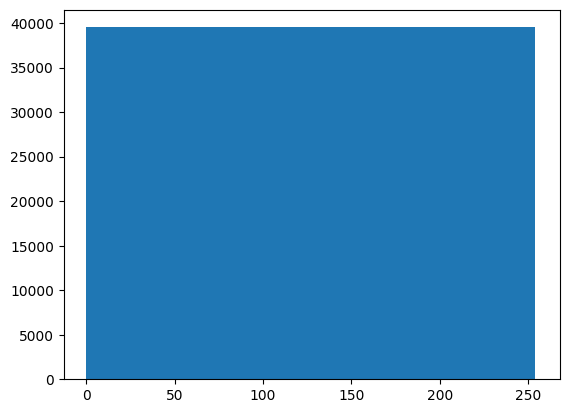

In [17]:
for i in range(u_size):
    v[i]=i//occurences
plt.hist(v, bins=256, range=(0,255))
plt.show()

> **En conclusion :**
> - **Avoir le même histogramme ne signifie pas être la même image.**
> - **La différence entre une image originale et son équivalent avec un histogramme prescrit ne sera pas une image noire, mais plutôt une image mettant en évidence les changements de valeurs de pixels.**

## 3.5 Dithering

**Quantifier une image -> La réduire à un nombre limité de niveaux de gris**

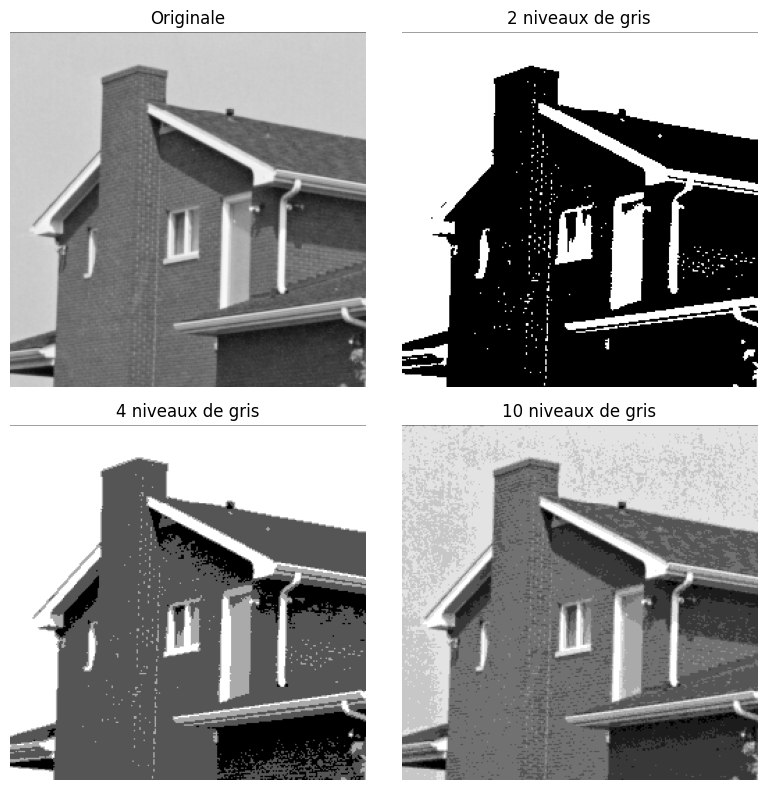

In [18]:
plt.figure(figsize=(8,8))

im=skio.imread('images/maison.tif')
plt.subplot(2,2,1)
plt.imshow(im,cmap='gray')
plt.title('Originale')
plt.axis('off')

im2=quantize(im,2)
plt.subplot(2,2,2)
plt.imshow(im2,cmap='gray')
plt.title('2 niveaux de gris')
plt.axis('off')

im4=quantize(im,4)
plt.subplot(2,2,3)
plt.imshow(im4,cmap='gray')
plt.title('4 niveaux de gris')
plt.axis('off')

im10=quantize(im,10)
plt.subplot(2,2,4)
plt.imshow(im10,cmap='gray')
plt.title('10 niveaux de gris')
plt.axis('off')

plt.tight_layout()
plt.show()

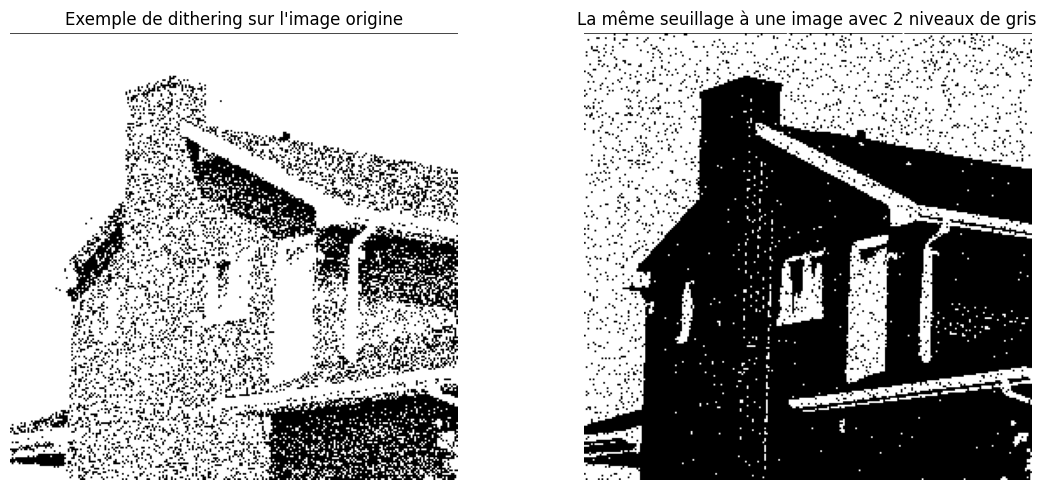

In [19]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(seuil(noise(im,30),80),cmap='gray') #exemple de dithering
plt.title('Exemple de dithering sur l\'image origine')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(seuil(noise(im2,30),80),cmap='gray') #exemple de dithering
plt.title('La même seuillage à une image avec 2 niveaux de gris')
plt.axis('off')

plt.tight_layout()
plt.show()

On constate qu'après avoir appliquer le bruit on parvient à retourver plus facilement la forme de la maison et on peut capturer plus l'allure globale de l'image en utilisant 2 niveaux de grix uniquement.

On ajoutant du bruit à l'images, on remarque que les points qui etait proches de seuil ont pu franchir cette barriere avec le bruit (donc ils deviennent blancs) et vis versa, tandis que les points qui etaient loin ont une forte probabilité de changer de valeur apres seuillage.

En guise de conclusion plus une zone presente de la lumiere plus il sera probable que cette zone depasse le seuil apres ajout de bruit plus de point on aura ce qui explique le resultat obtenu.
> **L'image détramée ressemble plus à l'image de départ que l'image simplement suillée**

## 3.6 Différences de niveaux de gris voisins

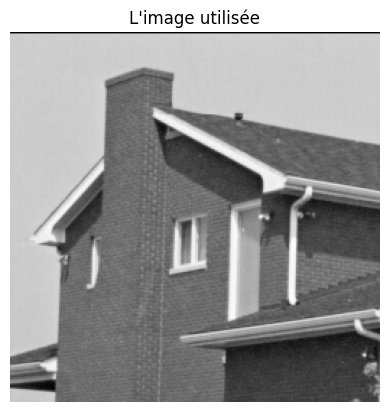

In [20]:
plt.imshow(im,cmap='gray')
plt.title('L\'image utilisée')
plt.axis('off')
plt.show()

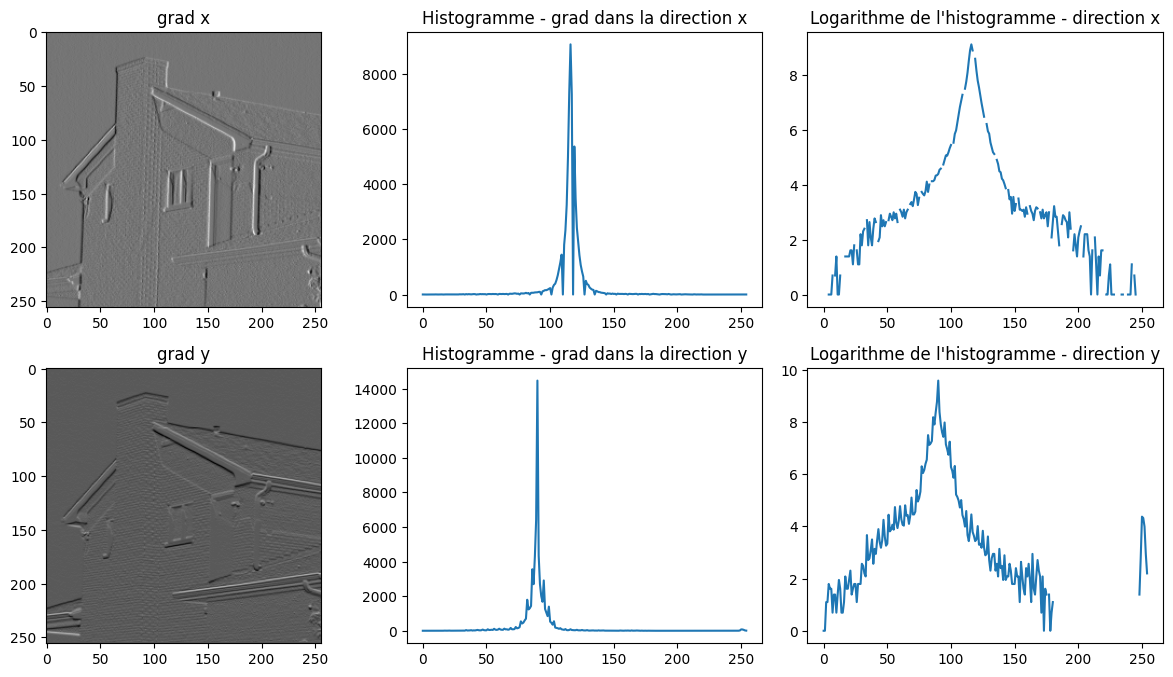

In [21]:
plt.figure(figsize=(12,10))

plt.subplot(331)
plt.imshow(gradx(im),cmap='gray')
plt.title('grad x')


plt.subplot(332)
plt.plot(np.histogram(gradx(im),255)[0])
plt.title('Histogramme - grad dans la direction x')

plt.subplot(333)
plt.plot(np.log(np.histogram(gradx(im),255)[0]))
plt.title('Logarithme de l\'histogramme - direction x')


plt.subplot(334)
plt.imshow(grady(im),cmap='gray')
plt.title('grad y')

plt.subplot(335)
plt.plot(np.histogram(grady(im),255)[0])
plt.title('Histogramme - grad dans la direction y')

plt.subplot(336)
plt.plot(np.log(np.histogram(grady(im),255)[0]))
plt.title('Logarithme de l\'histogramme - direction y')


plt.tight_layout()
plt.show()

oui la distribution des differences semble à une distribution gaussienne. En fait sauf au boards d'un objet, les pixels voisins ont à peu pres la memes valeur ce qui explique le pics au voisinage de 0. En faisant la difference entre deux point éloigné on peut trouver des autres graphes mais il est fort probable que ces deux points sont incorrelé l'un de l'autre et donc on aura un histogramme uniforme 

> **En analysant les histogrammes des gradients, on a constaté que la distribution des différences de niveaux de gris entre pixels voisins ressemble à une gaussienne. Ceci est dû au fait que, dans les régions homogènes d'une image, les pixels voisins ont tendance à avoir des valeurs similaires.**

# 4. Spectre des images et transformation de Fourier 

## 4.1 Visualisation de spectres

In [22]:
im=skio.imread('images/maison.tif')

In [23]:
help(view_spectre)

Help on function view_spectre in module __main__:

view_spectre(im, option=1, hamming=False)
    affiche le spectre d'une image
    si option =1 on affiche l'intensite de maniere lineaire
    si option =2 on affiche le log
    si hamming=True (defaut False) alors une fenetre de hamming est appliquee avant de prendre la transformee de Fourier



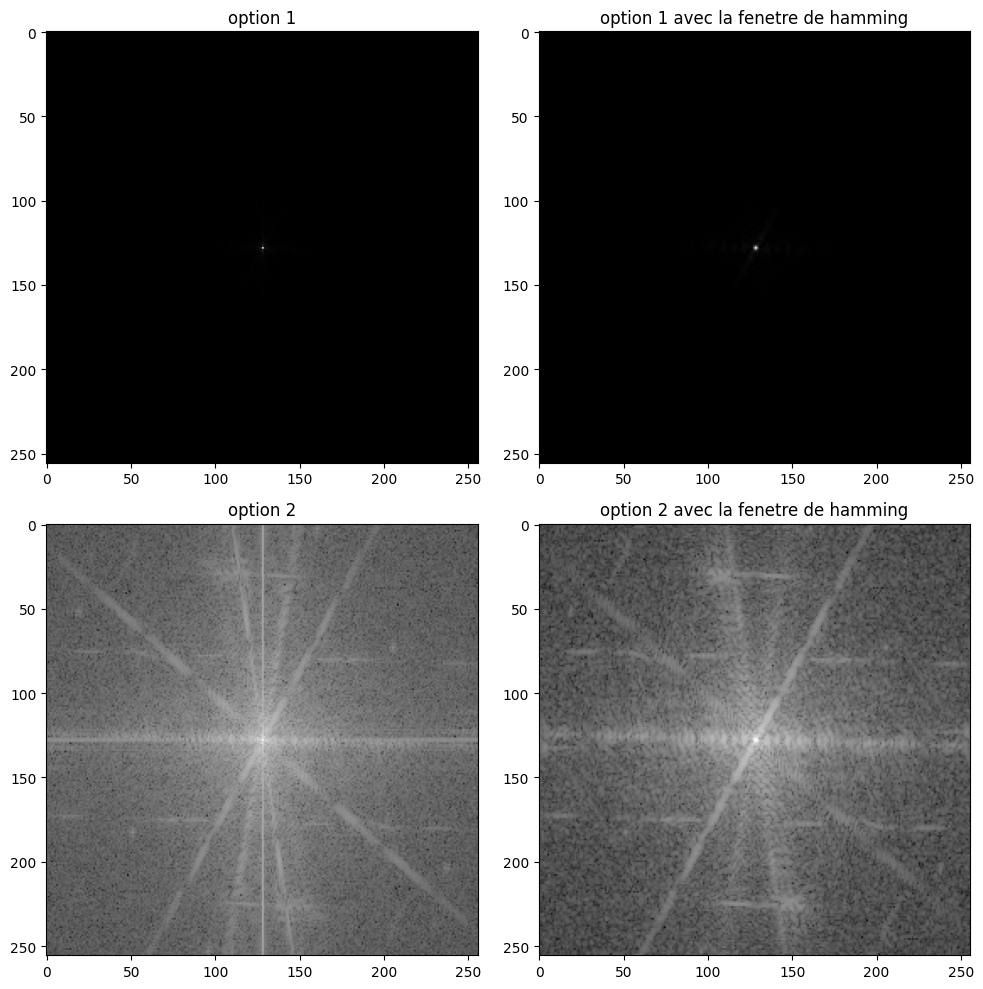

In [24]:
plt.figure(figsize=(10,10))

plt.subplot(221)
view_spectre(im,option=1,hamming=False)
plt.title('option 1')

plt.subplot(222)
view_spectre(im,option=1,hamming=True)
plt.title('option 1 avec la fenetre de hamming')


plt.subplot(223)
view_spectre(im,option=2,hamming=False)
plt.title('option 2')

plt.subplot(224)
view_spectre(im,option=2,hamming=True)
plt.title('option 2 avec la fenetre de hamming')

plt.tight_layout()
plt.show()

On remarque que lorsqu'on prend l'echelle linéaire le spectre de l'image de la maison est presque invisible il est representé par un point blanc dans le milieu. ceci est du au fait que le point centrale contient la somme de toutes les valeurs ce qui donne des valuers très grandes par rapport au autres donc c'est la seule valeurs qui apparait 
- **pour l'echelle logarithmique le spectre est plus clair.**

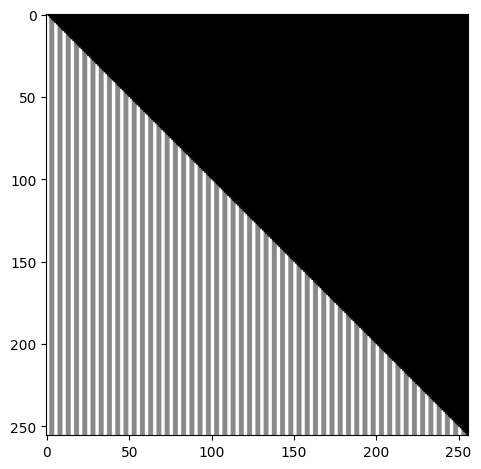

In [25]:
im=skio.imread('images/rayures.tif')

plt.imshow(im,cmap='gray')

plt.tight_layout()
plt.show()


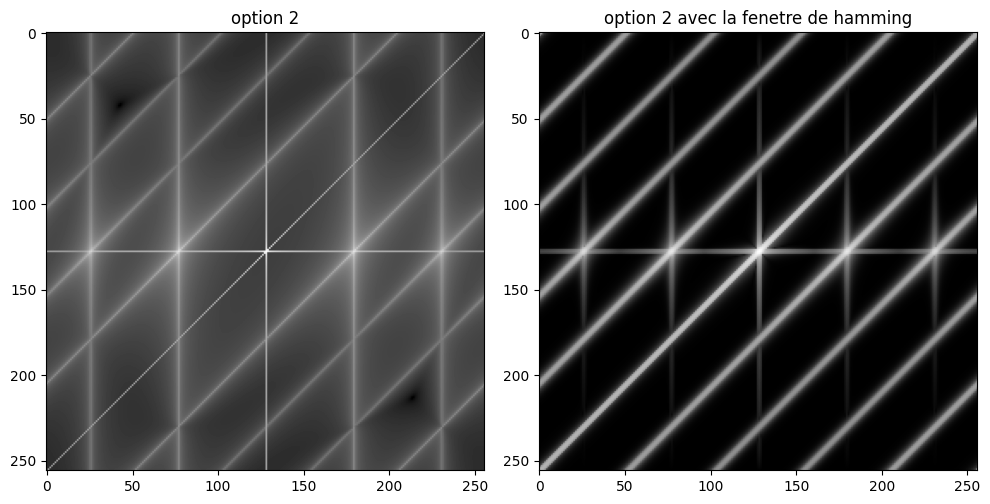

In [26]:
plt.figure(figsize=(10,10))

plt.subplot(221)
view_spectre(im,option=2,hamming=False)
plt.title('option 2')

plt.subplot(222)
view_spectre(im,option=2,hamming=True)
plt.title('option 2 avec la fenetre de hamming')



plt.tight_layout()
plt.show()

On constate que dans le spectre on a des lignes de direction orthogonal à celle des rayures, ce ceci est du au convolution entre le spectre de la meme image mais sans rayures (image moitié blanc moitié noire) dont le spectre est une ligne orthogonale a celle de la transition du couleur et l'image qui contient juste les rayures dont le spectre sera des point suivant la direction orthogonale des rayues. En faire l'image de rayures peut etre vu comme la somme des deux images decrites precedement d'ou la convolution des spectres.

> Le filtre de hammining est un filtre qui attenu les discontinuté au bords on annulant sa valeur. donc on visualision le spectre du nouvelle image apres l'application du filtre de hamming on constate que les lignes horizentaux et virticaux sont enorment attenué car on n'a plus de discontinué au bord.

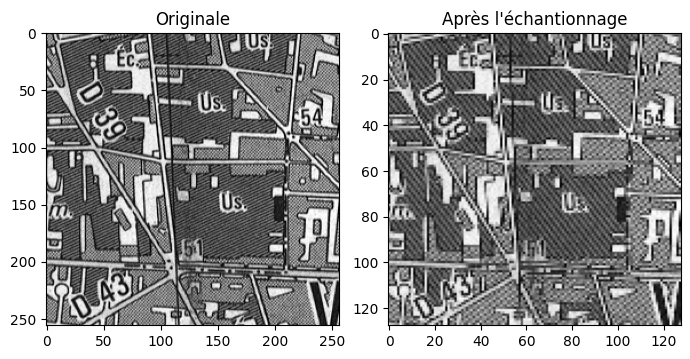

In [27]:
im2=skio.imread("images/carte_nb.tif")

plt.figure(figsize=(7,7))

plt.subplot(221)
plt.imshow(im2,cmap='gray')
plt.title('Originale')

# echantionnage en prenant un pixel sur deux dans les deux directions
plt.subplot(222)
im_ech=np.zeros((128,128))
im_ech=im2[::2,::2]
plt.imshow(im_ech,cmap='gray')
plt.title('Après l\'échantionnage')



plt.tight_layout()
plt.show()

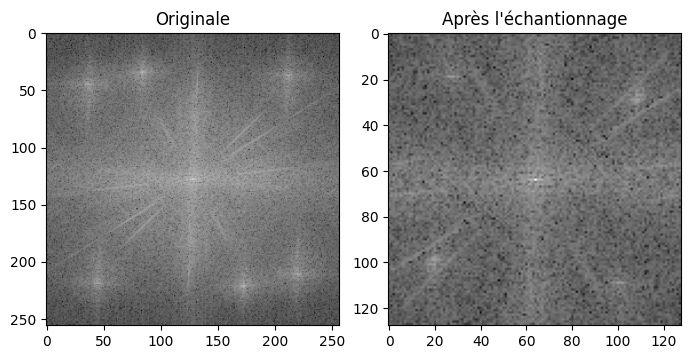

In [28]:
plt.figure(figsize=(7,7))

plt.subplot(221)
view_spectre(im2,2)
plt.title('Originale')

plt.subplot(222)
view_spectre(im_ech,2)
plt.title('Après l\'échantionnage')

plt.tight_layout()
plt.show()

Le spectre a une taille plus reduitre que celui de l'image orignialle (voir la difference dans l'echelle) et presente l'effet de repliment et on a perdu de l'infromation

> **Le sous-échantillonnage consiste à réduire la résolution d'une image, peut entraîner un repliement de spectre (aliasing). on a observé ce phénomène sur 'carte_nb.tif'. Le repliement de spectre se traduit par l'apparition de motifs indésirables dans l'image sous-échantillonnée.**

## 4.2 Ringing

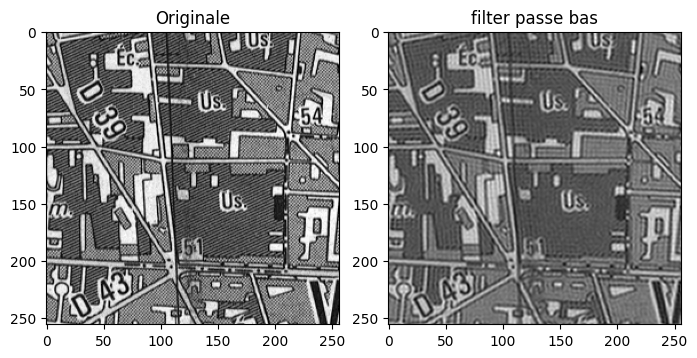

In [29]:
im2=skio.imread("images/carte_nb.tif")

plt.figure(figsize=(7,7))

plt.subplot(221)
plt.imshow(im2,cmap='gray')
plt.title('Originale')

plt.subplot(222)
plt.imshow(filterlow(im2),cmap='gray')
plt.title('filter passe bas')

plt.tight_layout()
plt.show()

On remarque que on a perdu de la luminsité de l'image. Ceci est prévisible car on a annuler certaine region de domaine frequentielle donc on a diminué l'energie de l'image. Cependant l'image reste de bonne qualité et on peut reconnaitre plus aspect. 
> **on a observé que le filtre passe-bas parfait peut provoquer un phénomène de "ringing" (apparition de halos autour des contours).**

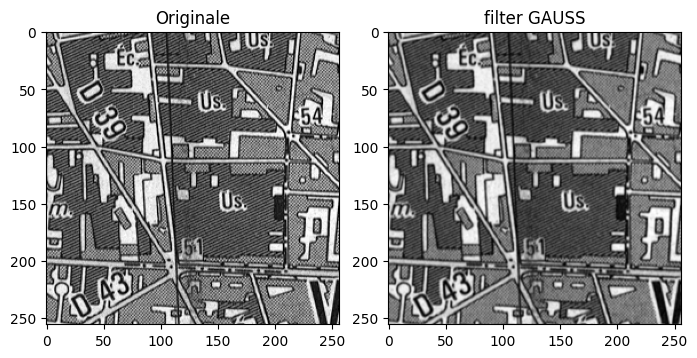

In [30]:
plt.figure(figsize=(7,7))

plt.subplot(221)
plt.imshow(im2,cmap='gray')
plt.title('Originale')

plt.subplot(222)
plt.imshow(filtergauss(im2),cmap='gray')
plt.title('filter GAUSS')

plt.tight_layout()
plt.show()

> **Le filtre gaussien, en revanche, produit un résultat plus lisse car sa réponse impulsionnelle est plus régulière.**

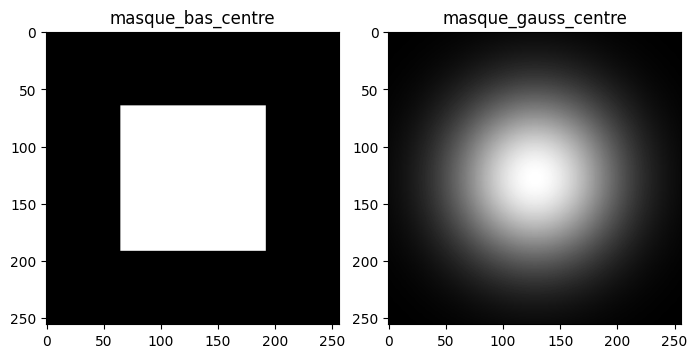

In [31]:
plt.figure(figsize=(7,7))

plt.subplot(221)
plt.imshow(skio.imread("images/masque_bas_centre.tif"),cmap='gray')
plt.title('masque_bas_centre')

plt.subplot(222)
plt.imshow(skio.imread("images/masque_gauss_centre.tif"),cmap='gray')
plt.title('masque_gauss_centre')

plt.tight_layout()
plt.show()

En visualisant les deux filtres on remarque que le filtre passe bas parfait presente une grande discontinuité dans le domaine spectrale celui ci va induire une convolution avec une fonction à support infini dans le domaine spatial et puisque la transformé inverse de la fonction carré est un sinus cardinale alors on aura des rayures supplementaire => c'est le phenomene de ringing. tandis que pour le filtre gaussien on a pas cette discontinuité ce qui explique que ce phenomene est d'autant plus attenu dans la derniere image

> **Le filtre passe-bas parfait a un spectre carré. Il coupe brusquement les fréquences au-delà d'un certain seuil (voir "masque_bas_centre.tif"). C'est cette coupure brutale qui crée une discontinuité.**
> 
> **Le filtre gaussien, lui, a un spectre qui décroît progressivement (voir "masque_gauss_centre.tif"), il n'y a donc pas de discontinuité brutale.**

- **En guise de conclusion :**
    Le filtre passe-bas gaussien, contrairement au filtre parfait, a un spectre qui décroît progressivement sans discontinuité brutale ("masque_gauss_centre.tif"). Cela permet d'éviter la création d'ondulations lors de la convolution et donc de minimiser le phénomène de ringing. L'image filtrée est plus douce et ne présente pas les artefacts indésirables du filtre parfait.